# Modelo *RMFT* ($\sigma$-$\omega$) con Autointeracción del Campo Escalar

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares

import scripts.AutointeractuanteEoS as AIEoS

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Habiendo definido los términos de autointeracción del campo escalar en unidades geometrizadas

$$U(\sigma) = \frac{1}{3}b\frac{m}{\hbar}(g_\sigma\sigma)^3+\frac{1}{4}c(g_\sigma\sigma)^4,$$

podemos escribir las ecuaciones de autoconsistencia, energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m$, $\tilde n = (\hbar^3/m^3)n$, $x = p/m$, $\tilde A_{\sigma} = (g_\sigma/m_\sigma)^2m^2/\hbar$, $\tilde A_{\omega} = (g_\omega/m_\omega)^2m^2/\hbar$, $\tilde{b}=\hbar^2b$ y $\tilde{c}=\hbar^3c$; y la constante $\lambda = m^4/\hbar^3$

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{2}{\pi^2} \int_0^{x_F(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} - \tilde b (1-\tilde x_{\sigma})^2 - \tilde c (1-\tilde x_{\sigma})^3\right] = 0$$
$$ \tilde\rho = \frac{\lambda}{2\rho_0} \left[(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3}\tilde b(1-\tilde x_{\sigma}) + \frac{1}{2}\tilde c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{\pi^2} \int_0^{x_F(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right]$$
$$ \tilde P = \frac{\lambda}{2\rho_0} \left[-(1-\tilde x_{\sigma})^2\left(\frac{1}{\tilde A_{\sigma}} + \frac{2}{3}\tilde b(1-\tilde x_{\sigma}) + \frac{1}{2}\tilde c(1-\tilde x_{\sigma})^2\right) + \tilde A_{\omega}^2 \tilde n^2 + \frac{4}{3\pi^2} \int_0^{x_F(n)} \frac{x^4}{\sqrt{x^2 + \tilde x_{\sigma}^2}} dx\right]$$

### Ecuación de estado numérica

In [2]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg
e_MKS = 1.602186021766e-19 # J

# # Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m
lambda_ = m_nuc**4/hbar**3 # Constante de escala empleada
rho_0_lambda = lambda_/2 # Escala de energía y presión empleada

# Damos valores a las constantes (fijadas con n_sat y (B/A)_sat) (constantes tilde cuadradas)
A_sigma = 330.263 # Walecka: 266.9, 357.4
A_omega = 249.547 # Walecka: 195.7, 273.8
b_ = 5e-4
c_ = 5e-4
params = [A_sigma, A_omega, b_, c_]

# Calculamos si no hay archivo de la EoS, si no, lo leemos
operacion = 'leer' # 'calc' o 'leer'

if operacion == 'calc':
    # Definimos el rango de densidades para la interpolación de la EoS
    densidad_masa_max = 1e18*1e3 # g/cm^3 a kg/m^3
    densidad_masa_min = 1e10*1e3 # g/cm^3 a kg/m^3
    n_barions = np.logspace(np.log10(densidad_masa_min/m_nuc_MKS), np.log10(densidad_masa_max/m_nuc_MKS), 200)
    # Calculamos la EoS
    rho_P, presiones, energias, n_sirve, presion_cambio = AIEoS.EoS(n_barions, params)
    df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
    df.to_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
elif operacion == 'leer':
    # Leemos los resultados de la EoS
    df = pd.read_csv('EoS_tables/SigmaOmegaAuto_rho0_lambda_A_propios.csv')
    n_sirve = df['n'].values
    presiones = df['P'].values
    energias = df['E'].values
    rho_P = CubicSpline(presiones, energias)

## Resultados de la EoS

### Ecuación de autoconsistencia

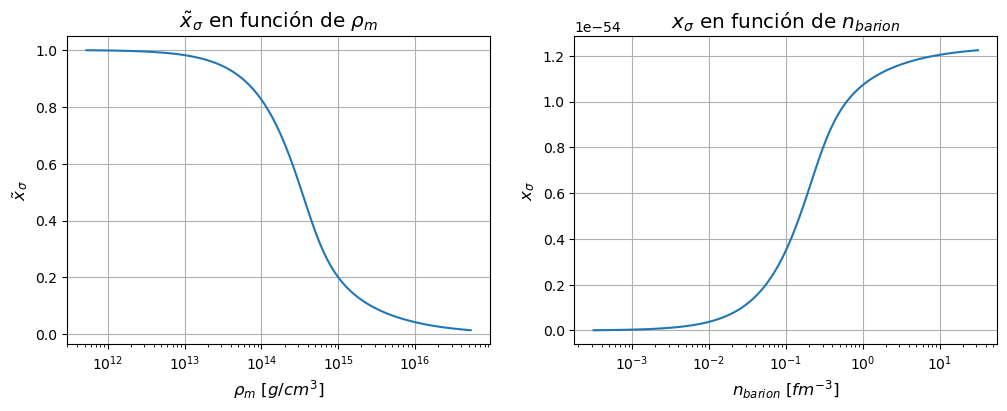

In [3]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(-3.5, 1.5, 100)*1e45
AIEoS.plot_autoconsistencia(n_prove, params)

### Interpolación y ecuación de estado

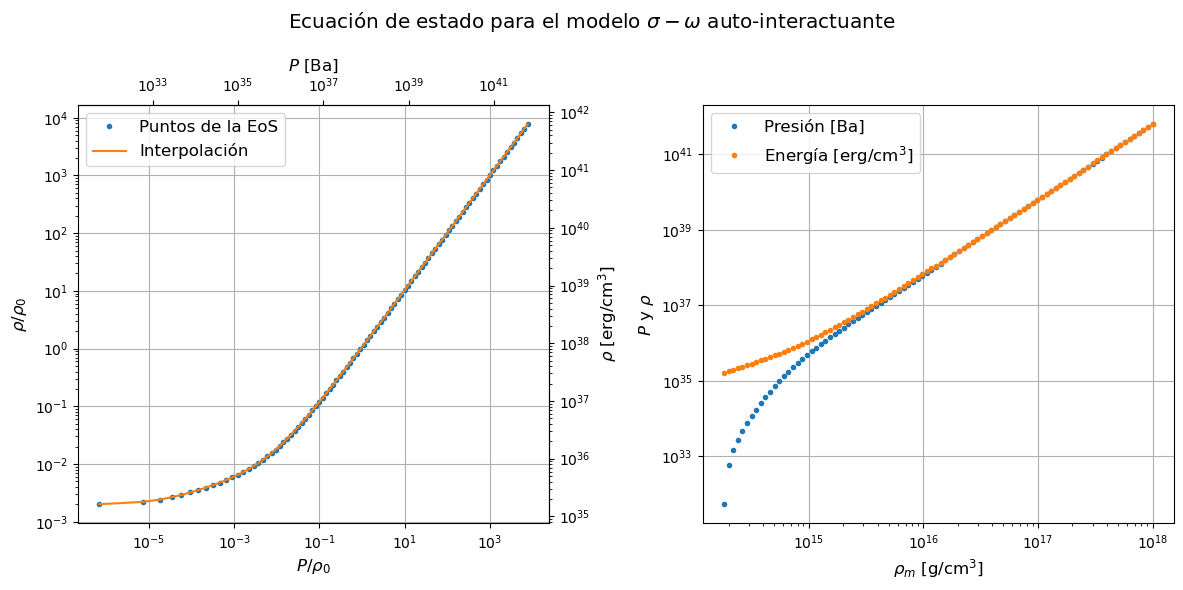

In [6]:
AIEoS.plot_EoS(rho_P, presiones, energias, n_sirve, titulo=r'Ecuación de estado para el modelo $\sigma-\omega$ auto-interactuante')

### Observables $\frac{B}{A}$ y $n_{sat}$

La masa efectiva en saturación es: 0.701 m_nuc
Densidad de saturación n_saturacion = 0.107 1/fm^3 y energia de enlace por nucleon en saturación = -7.658 MeV y densidad de energia en saturación = 99.908 MeV/fm^3
Presion en la densidad de saturación: -1.6984185722726864e+30 Pa


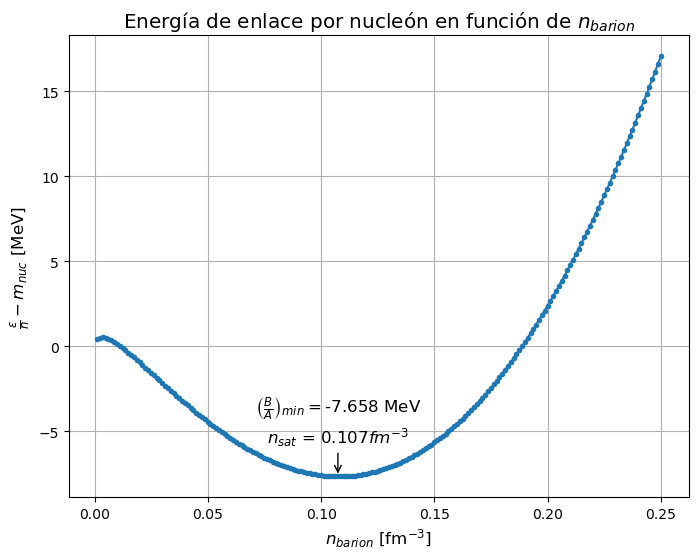

Saturacion:  [np.float64(1.0735678391959798e+44), np.float64(-1.0137970506873984e-56)]


In [4]:
# Graficamos la energia de enlace por nucleon vs la densidad de bariones
# n_prove = np.logspace(-3, -0.5, 200)*1e45 # Densidades de bariones de fm^-3 a m^-3
n_prove = np.linspace(1e-3, 0.25, 200)*1e45 # Densidades de bariones de fm^-3 a m^-3
saturacion = AIEoS.plot_saturacion(n_prove, params)
print('Saturacion: ', saturacion)

### Estimación de los parámetros $\tilde{A}_{\sigma}$, $\tilde{A}_{\omega}$, $\tilde{b}$ y $\tilde{c}$ a partir de $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$ 

In [5]:
# Calculamos el modulo de compresion y el coeficiente de energía de simetría
K = AIEoS.modulo_compresion(saturacion[0], [A_sigma, A_omega, b_, c_])
print(f'Modulo de compresion: {K*c_MKS**4/G_MKS/e_MKS*1e-6:.3f}MeV')

a_sym = AIEoS.coeficiente_simetria(saturacion[0], [A_sigma, A_omega, b_, c_])
print(f'Coeficiente de simetria: {a_sym*c_MKS**4/G_MKS/e_MKS*1e-6:.3f}MeV')

Modulo de compresion: 160.369MeV
Coeficiente de simetria: 12.686MeV


In [ ]:
from lmfit import minimize, create_params, report_fit

# Valores conocidos de las propiedades nucleares
n_saturacion_0 = 0.161               # fm^-3
binding_energy_0 = -16.24            # MeV
compression_modulus_0 = 230.0        # MeV
energy_symmetry_coefficient_0 = 31.6 # MeV
known_values = np.array([n_saturacion_0, binding_energy_0, compression_modulus_0, energy_symmetry_coefficient_0])

# Función residual para lmfit
def residual(params, n_barions, known_values):
    param_vector = [params['A_sigma'].value, params['A_omega'].value, params['b'].value, params['c'].value]
    calculated_values = AIEoS.calculate_properties(n_barions, param_vector)
    return calculated_values - known_values

# Definimos el rango de densidades para buscar saturación
n_prove = np.logspace(-2, 1, 100) * 1e45  # m^-3

# Utilizamos create_params de lmfit para definir los parámetros
params_lm = create_params(A_sigma=A_sigma, A_omega=A_omega, b=b_, c=c_)

# Realizamos la optimización utilizando lmfit con el método leastsq
result = minimize(residual, params_lm, args=(n_prove, known_values), method='leastsq', xtol=1e-8)
report_fit(result)

# Extraemos los parámetros optimizados y calculamos las propiedades nucleares
# opt_params = result.params
# optimized_vector = [opt_params['A_sigma'].value, opt_params['A_omega'].value, opt_params['b'].value, opt_params['c'].value]
# optimized_properties = AIEoS.calculate_properties(n_prove, optimized_vector)
# optimized_residuals = result.residual

# print("Estado de terminación: ", result.success)
# print("Parámetros óptimos:")
# print(f"A_sigma: {opt_params['A_sigma'].value:.3f}")
# print(f"A_omega: {opt_params['A_omega'].value:.3f}")
# print(f"b: {opt_params['b'].value:.3e}")
# print(f"c: {opt_params['c'].value:.3e}")

# print("\nPropiedades nucleares:")
# print(f"Densidad de saturación: {optimized_properties[0]:.3f} fm^-3 -> error: {optimized_residuals[0]:.3f} fm^-3")
# print(f"Energía de enlace por nucleón: {optimized_properties[1]:.3f} MeV -> error: {optimized_residuals[1]:.3f} MeV")
# print(f"Módulo de compresión: {optimized_properties[2]:.3f} MeV -> error: {optimized_residuals[2]:.3f} MeV")
# print(f"Coeficiente de energía de simetría: {optimized_properties[3]:.3f} MeV -> error: {optimized_residuals[3]:.3f} MeV")

No se encontró solución para n_barion =  3.5111917342151304e+43
No se encontró solución para n_barion =  3.764935806792467e+43
No se encontró solución para n_barion =  4.0370172585965534e+43
No se encontró solución para n_barion =  4.3287612810830568e+43
No se encontró solución para n_barion =  4.641588833612779e+43
No se encontró solución para n_barion =  4.977023564332111e+43
No se encontró solución para n_barion =  5.33669923120631e+43
No se encontró solución para n_barion =  5.722367659350217e+43
No se encontró solución para n_barion =  6.135907273413172e+43
No se encontró solución para n_barion =  6.579332246575682e+43
No se encontró solución para n_barion =  7.054802310718645e+43
No se encontró solución para n_barion =  7.564633275546291e+43
No se encontró solución para n_barion =  8.111308307896872e+43
No se encontró solución para n_barion =  8.697490026177833e+43
No se encontró solución para n_barion =  9.3260334688322e+43
No se encontró solución para n_barion =  9.999999999999

ValueError: The array returned by a function changed size between calls

In [13]:
(1.0/m_nuc)*hbar*(3.0*pi**2*1e42/2.0)**(1/3)

0.05164021085580653

In [14]:
# Definimos los valores conocidos de las propiedades nucleares
n_saturacion_0 = 0.161  # Densidad de saturación en fm^-3
binding_energy_0 = -16.24  # Energía de enlace por nucleón en MeV
compression_modulus_0 = 230.0 # Módulo de compresión en MeV
energy_symmetry_coefficient_0 = 31.6 # Coeficiente de energía de simetría en MeV
known_values = np.array([n_saturacion_0, binding_energy_0, compression_modulus_0, energy_symmetry_coefficient_0])

# Definimos la función objetivo para la optimización
def objective_function(params, n_barions):
    calculated_values = AIEoS.calculate_properties(n_barions, params)
    return (calculated_values - known_values)

# Definimos el punto inicial para la optimización (guessing inicial)
# initial_guess = params.copy()
initial_guess = [A_sigma, A_omega, 5e-5, 5e-5] 

# Definimos el rango de densidades para buscar la saturación
n_prove = np.logspace(-2, 1, 100)*1e45 # m^-3

# Realizamos la optimización
result = least_squares(objective_function, initial_guess, args=[n_prove], method='lm', xtol=1e-8, gtol=1e-8, ftol=1e-8, max_nfev=1000)

# Imprimimos los resultados
optimized_params = result.x
optimized_residuals = result.fun
optimized_properties = AIEoS.calculate_properties(n_prove, optimized_params)
print("Estado de terminación: ", result.message)
# Mostramos los parametros optimos y las propiedades nucleares
print("Parametros optimos:")
print(f"A_sigma:{optimized_params[0]:.3f}")
print(f"A_omega:{optimized_params[1]:.3f}")
print(f"b_:{optimized_params[2]:.3e}")
print(f"c_:{optimized_params[3]:.3e}")
print("\nPropiedades nucleares:")
print(f"Densidad de saturación: {optimized_properties[0]:.3f} fm^-3 -> error: {optimized_residuals[0]:.3f} fm^-3")
print(f"Energía de enlace por nucleón: {optimized_properties[1]:.3f} MeV -> error: {optimized_residuals[1]:.3f} MeV")
print(f"Módulo de compresión: {optimized_properties[2]:.3f} MeV -> error: {optimized_residuals[2]:.3f} MeV")
print(f"Coeficiente de energía de simetría: {optimized_properties[3]:.3f} MeV -> error: {optimized_residuals[3]:.3f} MeV")

No se encontró solución para n_barion =  3.7649358067924674e+44
No se encontró solución para n_barion =  4.0370172585965555e+44
No se encontró solución para n_barion =  4.328761281083059e+44
No se encontró solución para n_barion =  4.641588833612779e+44
No se encontró solución para n_barion =  4.977023564332111e+44
No se encontró solución para n_barion =  5.336699231206309e+44
No se encontró solución para n_barion =  5.7223676593502166e+44
No se encontró solución para n_barion =  6.1359072734131725e+44
No se encontró solución para n_barion =  6.579332246575682e+44
No se encontró solución para n_barion =  7.0548023107186444e+44
No se encontró solución para n_barion =  7.56463327554629e+44
No se encontró solución para n_barion =  8.111308307896872e+44
No se encontró solución para n_barion =  8.697490026177834e+44
No se encontró solución para n_barion =  9.326033468832199e+44
No se encontró solución para n_barion =  1e+45
No se encontró solución para n_barion =  1.072267222010323e+45
No s